# Monk3
Grid Search for Monk1 dataset model selection


In [103]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk3
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from exclusiveAI.components.CallBacks import EarlyStoppingCallback
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk3 dataset 

In [104]:
training_data, training_labels, test_data, test_labels = read_monk3("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [105]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [106]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [107]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 64
epochs = 500

final_file = 'monk3_models_configs_hist2.json'

if not os.path.exists(final_file):
    dir_path = "Monk3/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    momentums = all_json_data['momentum'].unique().tolist()
    num_of_layers = [1]#all_json_data['num_layers'].unique().tolist()
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = ["uniform", "gaussian"]
    activations = ["sigmoid"]
    
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True,
                                     callbacks=["earlystopping"], output_activation='sigmoid', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, num_models=100, workers=8, number_of_initializations=3, return_models_history=True,
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json(final_file)
else: 
    with open(final_file, 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [108]:
models = []
old_histories = configs[0]
configs=configs[1]
with tqdm(total=len(configs)) as pbar:
    for old_hist, config in zip(old_histories, configs):
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, old_hist['binary_accuracy'][-1],  old_hist['val_binary_accuracy'][-1], old_hist['mee'],  old_hist['val_mee'], model.history['mee'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'Old_Accuracy', 'Old_Accuracy_val', 'Old_History', 'Old_History_val', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


In [112]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
# df_sorted = df_sorted[df_sorted['Accuracy'] >= 0.95]
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 0.96]
# df_sorted = df_sorted[df_sorted['History_Std'] <= 0.1] 
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
old_histories = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History']].values}
old_histories_val = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History_val']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,Old_Accuracy,Old_Accuracy_val,Old_History,Old_History_val,History,Model,Config,Num_Layers,Num_of_Units,Name
2,0.046024,0.067155,0.942623,0.040606,0.960648,500,0.958763,0.88,"[0.4942563176, 0.4942235649, 0.4943821728, 0.4...","[0.5113788247, 0.5100041032, 0.5079473257, 0.5...","[0.5018026, 0.50146353, 0.50115156, 0.50085, 0...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-08, 'learning_rate': 0.6...",1,[2],Model2463
14,0.046664,0.054888,0.942623,0.042916,0.960648,500,0.958763,0.88,"[0.4939247072, 0.4941289425, 0.4947008491, 0.4...","[0.5182678103, 0.5175830722, 0.5157054663, 0.5...","[0.49446318, 0.4937431, 0.4931274, 0.49255887,...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-08, 'learning_rate': 0.6...",1,[2],Model84
25,0.046764,0.062653,0.942623,0.040111,0.960648,500,0.958763,0.88,"[0.4984420836, 0.4981563985, 0.4978724122, 0.4...","[0.5135797858, 0.5135474205, 0.5133419633, 0.5...","[0.49821007, 0.49770263, 0.4972031, 0.49685156...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.2...",1,[2],Model8412
36,0.047221,0.071493,0.942623,0.043478,0.960648,500,0.958763,0.88,"[0.4974141121, 0.4969055057, 0.4962349236, 0.4...","[0.5073100924, 0.5083067417, 0.5096260309, 0.5...","[0.50682527, 0.5064586, 0.5059423, 0.5054874, ...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.25,...",1,[2],Model26124
29,0.048109,0.071604,0.942623,0.043547,0.960648,500,0.958763,0.88,"[0.4955272079, 0.4957939088, 0.495575279, 0.49...","[0.5172465444, 0.5161131024, 0.5165613294, 0.5...","[0.49913514, 0.49913362, 0.49912268, 0.4990834...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-08, 'learning_rate': 0.5...",1,[2],Model1308
61,0.048628,0.062380,0.942623,0.044247,0.960648,500,0.958763,0.88,"[0.5058833957, 0.5042217374, 0.5029378533, 0.5...","[0.4867524207, 0.4932169318, 0.4977272749, 0.5...","[0.493967, 0.49440783, 0.4947337, 0.49501464, ...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-05, 'learning_rate': 0.6...",1,[2],Model14703
15,0.048728,0.067471,0.942623,0.044420,0.960648,500,0.958763,0.88,"[0.4994479418, 0.4981013536, 0.49649629, 0.495...","[0.4848704934, 0.4884369373, 0.4927537143, 0.4...","[0.50209486, 0.5013792, 0.50058734, 0.50003606...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-08, 'learning_rate': 0.2...",1,[3],Model3805
34,0.048736,0.063016,0.942623,0.044751,0.960648,500,0.958763,0.88,"[0.4973275363, 0.4974291027, 0.4959939122, 0.4...","[0.5124812126, 0.5116301179, 0.5155174136, 0.5...","[0.49962625, 0.4994035, 0.4991911, 0.49898407,...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0001, 'learning_rate': 0....",1,[2],Model15564
87,0.049050,0.080500,0.942623,0.043328,0.960648,500,0.958763,0.88,"[0.4999079108, 0.4989641309, 0.4983145595, 0.4...","[0.4992603362, 0.5018841624, 0.503619194, 0.50...","[0.5040481, 0.50327927, 0.50264317, 0.5021048,...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.5...",1,[2],Model9876
62,0.049086,0.057099,0.942623,0.044516,0.960648,500,0.958763,0.88,"[0.4905892611, 0.4911213815, 0.4913811386, 0.4...","[0.5368509293, 0.5322180986, 0.5287334323, 0.5...","[0.49561518, 0.49536306, 0.49494627, 0.4945165...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.57,...",1,[4],Model25430


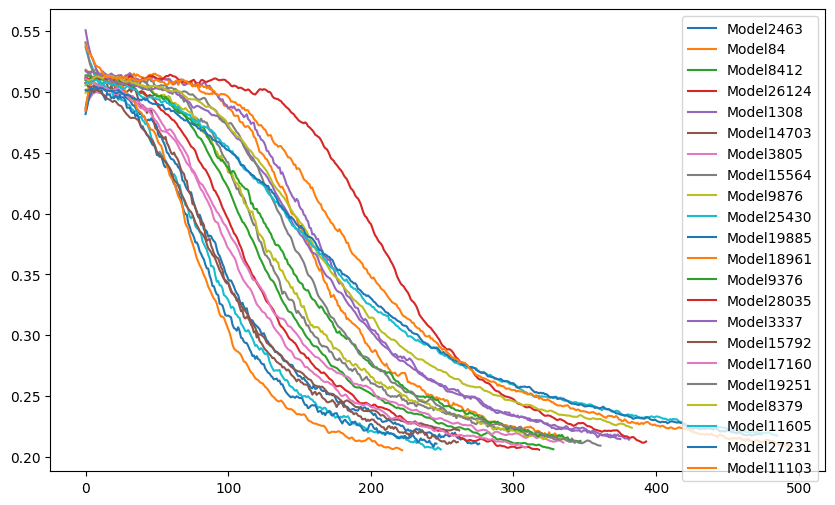

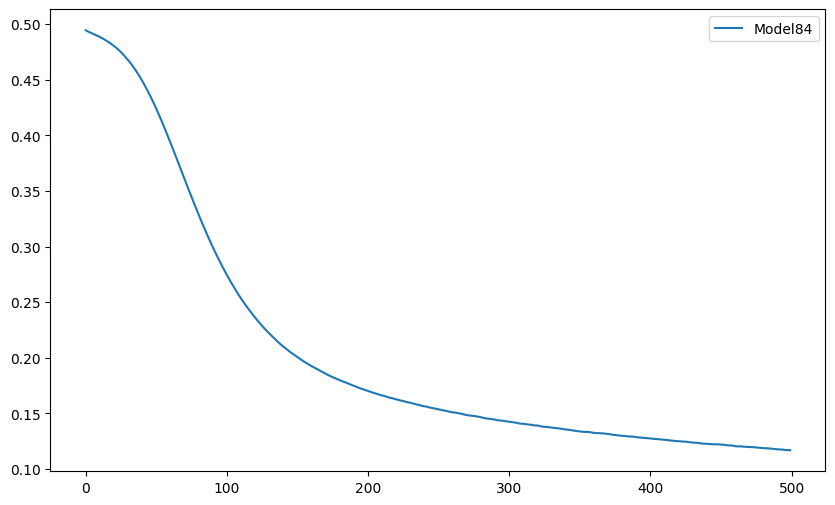

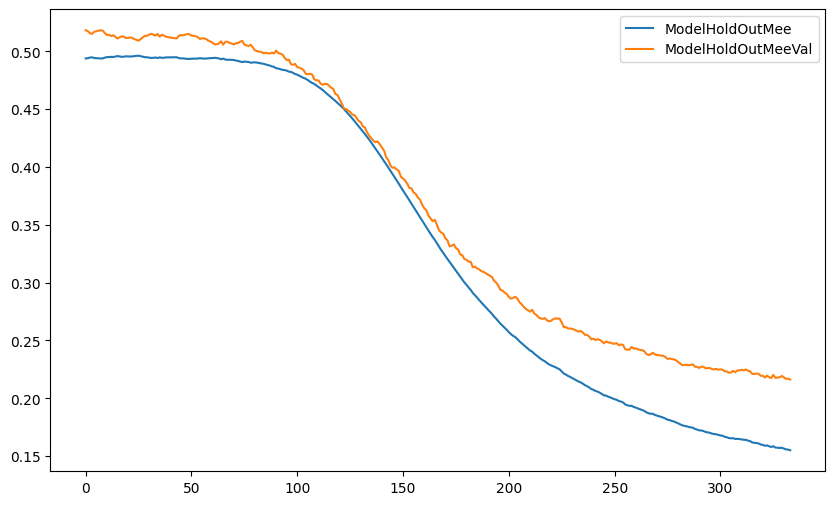

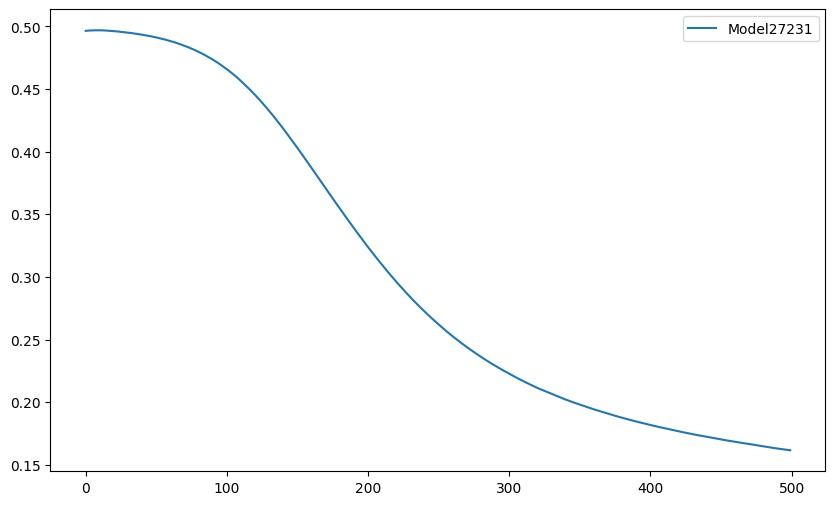

In [113]:
plot_history(old_histories_val)
plot_history({list(histories)[1]: list(histories.values())[1]})
plot_history({'ModelHoldOutMee': list(old_histories.values())[1], 'ModelHoldOutMeeVal': list(old_histories_val.values())[1]})
plot_history({'Model27231': histories['Model27231']})
# plot_history({list(histories)[1]: list(histories.values())[1]})


Selected row:
Score                                                        0.049102
History_Std                                                  0.068576
Accuracy                                                     0.942623
Test_Score                                                   0.044602
Test_Accuracy                                                0.960648
Trained_Epochs                                                    500
Old_Accuracy                                                 0.958763
Old_Accuracy_val                                                 0.88
Old_History         [0.5056889057, 0.5040260553, 0.5022172332, 0.5...
Old_History_val     [0.4818255305, 0.4870382547, 0.4932828844, 0.4...
History             [0.5059984, 0.5054942, 0.50501144, 0.50457066,...
Model               <exclusiveAI.components.NeuralNetwork.NeuralNe...
Config              {'regularization': 0.0001, 'learning_rate': 0....
Num_Layers                                                          1
Num_of

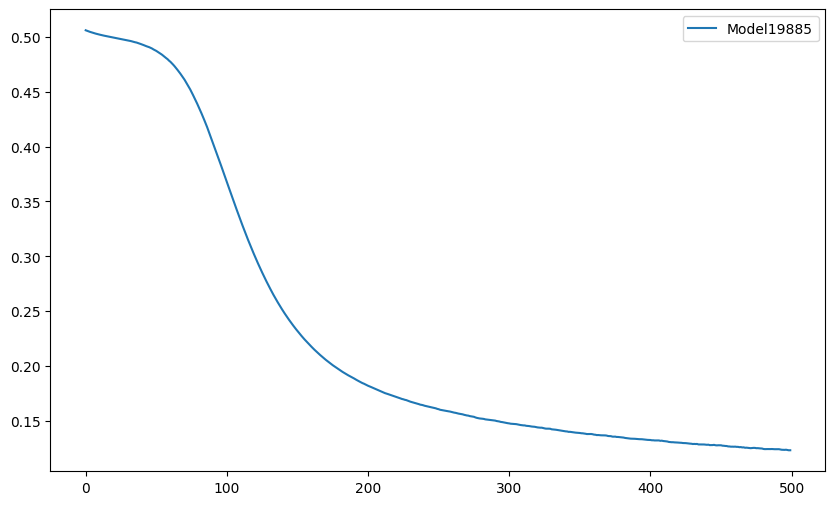

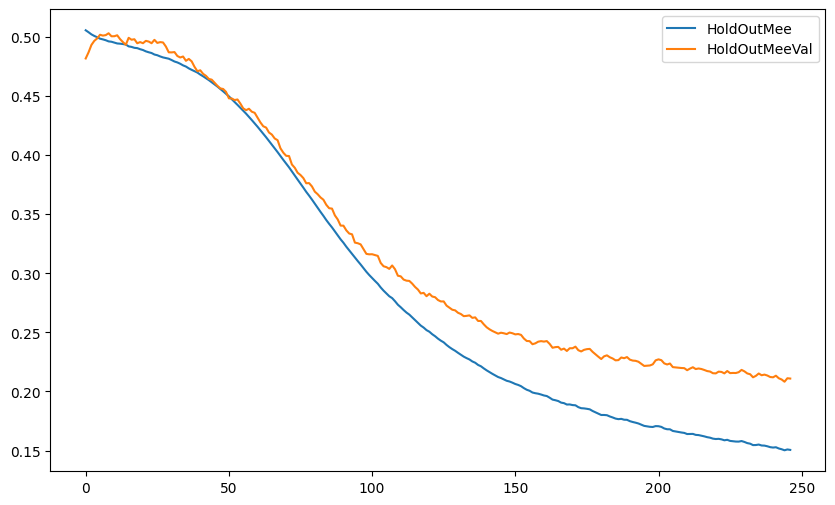

In [111]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array = np.array(row['History'])
        differences =  (np.diff(array)/ np.mean(array))
        min_consecutive_difference = np.min(differences)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

# Example usage:
result_row = find_least_difference_row(df_sorted)
print("Selected row:")
print(result_row)
plot_history({result_row["Name"]: result_row['History']})
plot_history({'HoldOutMee': result_row['Old_History'], 'HoldOutMeeVal': result_row['Old_History_val']})